# Recursive QAOA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import os

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
def run_Rqaoa_experiment(sigma, graph_seed, optimizer, init_seed, experiment_name):  
    
    mu = 5.0
    k = 3
    n=12
    
    g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

    # Define te problem and translate it into a binary Qubo.
    maxcut_prob = MaximumCut(g)
    maxcut_qubo = maxcut_prob.get_qubo_problem()
    
    cost_hamiltonian = maxcut_qubo.hamiltonian
    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
    print(analytical_energy)

    
    # Define the RQAOA object (default rqaoa_type = 'adaptive')
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    R.set_rqaoa_parameters(steps=1, n_cutoff=3)

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    #R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    
    random.seed(init_seed)
    init_beta = random.uniform(0, np.pi/2)
    init_gamma = random.uniform(0, 5*np.pi)

    print(init_beta)
    print(init_gamma)
    
    R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[init_beta], "gammas":[init_gamma]}, mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-3), maxfev=2000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    # Here are other ways in which the above selection can be generalized!

    # device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
    # r.set_device(device)
    # r.set_backend_properties(n_shots=100, cvar_alpha=1)
    # r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
    # r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)
    

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    try: 
        os.mkdir(experiment_name) 
    except OSError as error: 
        print(error)  
    
    # TODO save in the backup folder directly
    R.results.dump("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed))
    
    


In [5]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [6]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

In [7]:
def plot_landscape_with_opt_trajectory(cost_landscape, optimization_angles, betas, gammas, optimizer):
    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
        
    plt.plot(optimization_angles[:, 1], optimization_angles[:, 0], '--', color='black',  )  
    plt.plot(optimization_angles[0, 1], optimization_angles[0, 0], 'x', color='black',  ) 
    
    plt.plot(optimization_angles[-1, 1], optimization_angles[-1, 0], 'x', color='orange',  )

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    plt.savefig("cost_landscape_trajectory_optimizer={}.png".format(optimizer))
    plt.show()

## Run experiment: Averaging over initializations

In [ ]:
experiment_name = 'Maxcut_w3R_initializations' # to be used as a name for the folder containing all jsons for this experiment 

# structure of the name: problem_typeOfGraph[optional]_variableToInvestigate

sigma_list = [0.1]


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["cobyla"]

#graph_seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

graph_seed_list = [1]
init_seed_list = [1001]


for sigma in sigma_list:
    print("Sigma=", sigma)
    
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)

        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            
            for init_seed in init_seed_list:
                print("init_seed=", init_seed)
                
                run_Rqaoa_experiment(sigma, graph_seed, optimizer, init_seed, experiment_name)
                

### Analyze experiment

In [9]:
experiment_name = 'Maxcut_w3R_initializations' # to be used as a name for the folder containing all jsons for this experiment 

# structure of the name: problem_typeOfGraph[optional]_variableToInvestigate

sigma_list = [0.1, 1.0]
optimizer_list = ["rmsprop", "cobyla"]
graph_seed_list = [1, 2, 3]
init_seed_list = [1001, 1002, 1003]

mu = 5.0

data = []
for sigma in sigma_list:
    print("Sigma=", sigma)
    
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)

        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            
            for init_seed in init_seed_list:
                print("init_seed=", init_seed)

                # Opening JSON file
                with open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed)) as f:

                    # returns JSON object as a dictionary
                    opt_results = json.load(f)

                    # construct the original problem Hamiltonian from the initial QAOA 
                    qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                    terms = []
                    for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                        terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                    weights = qaoa_init['cost_hamiltonian']['coeffs']
                    const = qaoa_init['cost_hamiltonian']['constant']

                    cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                    # Calculate the approx. ratio
                    optimization_energy = list(opt_results['solution'].values())[0]

                    r = np.abs(optimization_energy) / np.abs(analytical_energy)

                    # Extract other params
                    optimization_schedule = list(opt_results['schedule'])

                    optimization_angles = np.array(opt_results['intermediate_steps'][3]['QAOA']['intermediate']['angles log'])
    
                    data.append([sigma, graph_seed, init_seed, r])
        



Sigma= 0.1
graph_seed= 1
Optimizer= rmsprop
init_seed= 1001
[[0.1, 1, 1001, 0.8598248424505078]]
init_seed= 1002
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829]]
init_seed= 1003
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1, 1003, 0.703162434448168]]
Optimizer= cobyla
init_seed= 1001
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1, 1003, 0.703162434448168], [0.1, 1, 1001, 1.0]]
init_seed= 1002
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1, 1003, 0.703162434448168], [0.1, 1, 1001, 1.0], [0.1, 1, 1002, 0.7076263544703829]]
init_seed= 1003
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1, 1003, 0.703162434448168], [0.1, 1, 1001, 1.0], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1, 1003, 0.7031021018582081]]
graph_seed= 2
Optimizer= rmsprop
init_seed= 1001
[[0.1, 1, 1001, 0.8598248424505078], [0.1, 1, 1002, 0.7076263544703829], [0.1, 1

In [10]:

df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'init_seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['init_seed'] = df['init_seed'].astype(int)
df['r'] = df['r'].astype(float)

In [12]:
df

,sigma,graph_seed,init_seed,r
0,0.1,1,1001,0.859825
1,0.1,1,1002,0.707626
2,0.1,1,1003,0.703162
3,0.1,1,1001,1.000000
4,0.1,1,1002,0.707626
5,0.1,1,1003,0.703102
6,0.1,2,1001,1.000000
7,0.1,2,1002,0.705443
8,0.1,2,1003,0.420944
9,0.1,2,1001,1.000000


<AxesSubplot: xlabel='sigma', ylabel='r'>

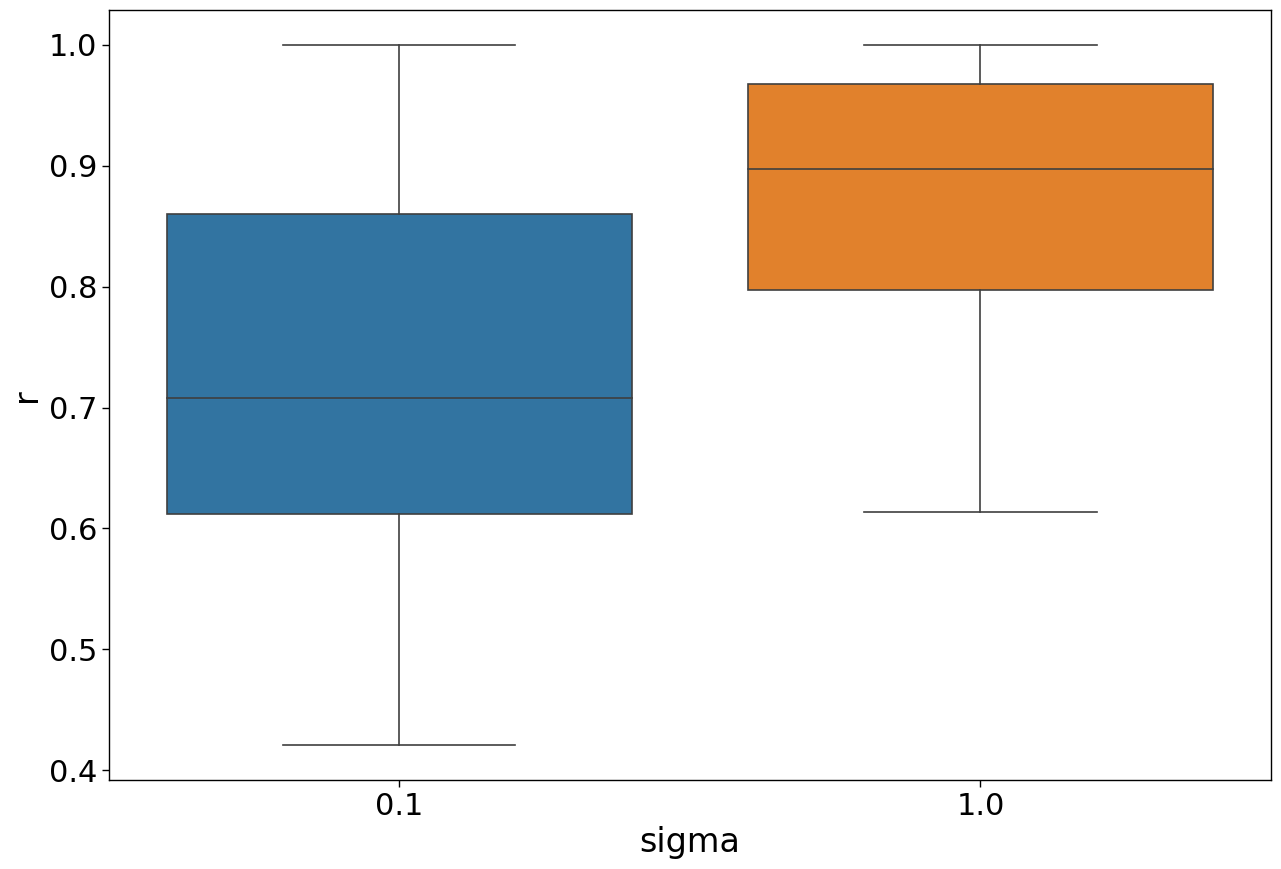

In [15]:
#plt.xscale('log')
#plt.ylim(0, 1)
sns.boxplot(data = df, x = 'sigma', y ='r') # averaging both over graph instances and initial seeds

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='init_seed') # shows which initialization is the best on average

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='graph_seed') # shows which graph (wigths) is easiest

#plt.savefig("{}.png".format(experiment_name))